In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import json

from collections import defaultdict, Counter
from torch.utils.data import DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
device

device(type='cuda')

In [ ]:
def normalize_parameters(loader, num_channels):
    mean = torch.zeros(num_channels)
    std = torch.zeros(num_channels)
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        for channel in range(num_channels):
            mean[channel] += images[:, channel, :, :].mean().item()
        total_images += batch_samples

    mean /= total_images

    variance = torch.zeros(num_channels)
    for images, _ in loader:
        batch_samples = images.size(0)
        for channel in range(num_channels):
            variance[channel] += ((images[:, channel, :, :] - mean[channel]) ** 2).mean().item()

    variance /= total_images
    std = variance ** 0.5

    return mean.tolist(), std.tolist()

In [ ]:
train_dataset = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)

mean, std = normalize_parameters(train_loader, num_channels=1)

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [6]:
train_dataset.__len__()

112800

In [ ]:
len_dataset = train_dataset.__len__()
batch_size = 16
total_steps = len_dataset // batch_size
learning_rate = .0005
num_classes = train_dataset.classes.__len__()
num_epochs = 5

In [5]:
print(train_dataset.classes[:15])
print(train_dataset.classes.__len__())
print(train_dataset.targets[:15])
print(train_dataset.targets.__len__())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E']
47
tensor([45, 36, 43, 15,  4, 42, 26, 32, 20,  1, 46, 43, 15, 13, 24])
112800


In [16]:
def get_model(model_name, num_classes, requires_grad=False):
    if model_name == "resnet18":
        model = models.resnet18(weights="DEFAULT")
        model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        for param in model.parameters():
            param.requires_grad = True if requires_grad else False
        
        for param in model.fc.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(weights="DEFAULT")
        model.features[0] = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        
        for param in model.features.parameters():
            param.requires_grad = True if requires_grad else False
        
        for param in model.classifier.parameters():
            param.requires_grad = True
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "inception_v3":
        model = models.inception_v3(weights="DEFAULT", aux_logits=True)
        model.Conv2d_1a_3x3.conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, bias=False)
        
        for param in model.parameters():
            param.requires_grad = True if requires_grad else False
        
        for param in model.fc.parameters():
            param.requires_grad = True
            
        for param in model.AuxLogits.fc.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    elif model_name == "densenet161":
        model = models.densenet161(weights="DEFAULT")
        model.features.conv0 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, bias=False)
        
        for param in model.features.parameters():
            param.requires_grad = True if requires_grad else False
        
        for param in model.classifier.parameters():
            param.requires_grad = True
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    return model.to(device)

In [14]:
def save_model(model, model_name, path="models/", name_data=None):
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, f"{model_name}_{name_data}.pth")
    torch.save(model.state_dict(), file_path)
    print(f"Model {model_name} saved to {file_path}")


def load_model(model_name, num_classes, path="models/", name_data=None, requires_grad=True):
    model = get_model(model_name, num_classes, requires_grad=requires_grad)
    file_path = os.path.join(path, f"{model_name}_{name_data}.pth")
    model.load_state_dict(torch.load(file_path, map_location=device))
    model.to(device)
    print(f"Model {model_name} loaded from {file_path}")
    return model


def save_results_to_json(results, path="models/", filename="results.json"):
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, filename)
    with open(file_path, 'w') as f:
        json.dump(dict(results), f, indent=4)
    print(f"Results saved to {file_path}")


def train_model(model, train_loader, num_epochs, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    loss_history = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        start = time.time()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if model_name == "inception_v3" and model.training:
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + .4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % (total_steps // 2) == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}.")

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        loss_history.append(avg_loss)
        print(f'Time {time.time() - start} sec, {model_name} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return loss_history


def test_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f'{model_name} Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [ ]:
transform_normalized_others = transforms.Compose([
    tv.transforms.Grayscale(3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset_normalized_others = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform_normalized_others,
    download=False
)

test_dataset_normalized_others = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform_normalized_others,
    download=False
)

In [ ]:
transform_normalized_inception = transforms.Compose([
    tv.transforms.Grayscale(3),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset_normalized_inception = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform_normalized_inception,
    download=False
)

test_dataset_normalized_inception = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform_normalized_inception,
    download=False
)

In [8]:
train_loader_others = DataLoader(dataset=train_dataset_normalized_others, batch_size=batch_size, shuffle=True)
test_loader_others = DataLoader(dataset=test_dataset_normalized_others, batch_size=batch_size, shuffle=False)

train_loader_inception = DataLoader(dataset=train_dataset_normalized_inception, batch_size=batch_size, shuffle=True)
test_loader_inception = DataLoader(dataset=test_dataset_normalized_inception, batch_size=batch_size, shuffle=False)

In [ ]:
model_names = ['inception_v3', "densenet161", "resnet18", "vgg16"]
results = defaultdict(list)

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes, requires_grad=True)

    train_loader = train_loader_others if model_name != 'inception_v3' else train_loader_inception
    test_loader = test_loader_others if model_name != 'inception_v3' else test_loader_inception

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    save_model(model, model_name, name_data="emnist")

    results['Dataset'].append("emnist")
    results['Model'].append(model_name)
    results['Test Loss'].append(test_loss)
    results['Test Accuracy'].append(test_accuracy)
    results['Train Loss History'].append(loss_history)

    save_results_to_json(results)


Training inception_v3...
Step 0. time since epoch: 0.488.
Step 3525. time since epoch: 484.232.
Time 974.2200047969818 sec, inception_v3 Epoch [1/5], Loss: 0.7493, Accuracy: 81.77%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_1.pth после эпохи 1
Step 0. time since epoch: 0.140.
Step 3525. time since epoch: 492.437.
Time 985.2813060283661 sec, inception_v3 Epoch [2/5], Loss: 0.5060, Accuracy: 87.02%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_2.pth после эпохи 2
Step 0. time since epoch: 0.147.
Step 3525. time since epoch: 491.156.
Time 980.873610496521 sec, inception_v3 Epoch [3/5], Loss: 0.4368, Accuracy: 88.49%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_3.pth после эпохи 3
Step 0. time since epoch: 0.141.
Step 3525. time since epoch: 494.984.
Time 983.0786068439484 sec, inception_v3 Epoch [4/5], Loss: 0.3962, Accuracy: 89.36%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_4.pth после эпохи 4
Step 0. tim

100.0%


Step 0. time since epoch: 0.252.
Step 3525. time since epoch: 785.917.
Time 1571.9584267139435 sec, vgg16 Epoch [1/5], Loss: 3.8596, Accuracy: 2.09%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_1.pth после эпохи 1
Step 0. time since epoch: 0.237.
Step 3525. time since epoch: 785.733.
Time 1571.0589008331299 sec, vgg16 Epoch [2/5], Loss: 3.8531, Accuracy: 2.15%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_2.pth после эпохи 2
Step 0. time since epoch: 0.226.
Step 3525. time since epoch: 785.527.
Time 1571.035100698471 sec, vgg16 Epoch [3/5], Loss: 3.8522, Accuracy: 2.11%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_3.pth после эпохи 3
Step 0. time since epoch: 0.228.
Step 3525. time since epoch: 785.869.
Time 1571.1184408664703 sec, vgg16 Epoch [4/5], Loss: 3.8516, Accuracy: 2.06%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_4.pth после эпохи 4
Step 0. time since epoch: 0.226.
Step 3525. time since epoch: 815.627.
Time 1650.6189801692963 sec, vgg16 Epoch [5/5], Lo

In [21]:
df = pd.DataFrame({
    'Model': results['Model'],
    'Test Loss': [f"{x:.4f}" for x in results['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0  inception_v3    0.2981             89.87
1   densenet161    0.2961             89.42
2      resnet18    0.2992             89.77
3         vgg16    3.8504              2.13


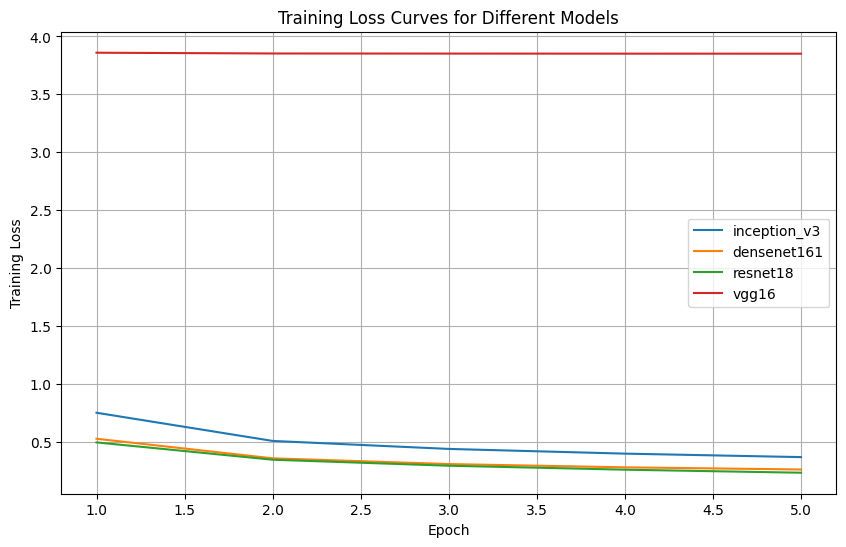

In [22]:
plt.figure(figsize=(10, 6))
for model_name, loss_history in zip(results['Model'], results['Train Loss History']):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

**Dataset Hymenoptera**

In [5]:
import kagglehub

path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

/home/borealis/Documents/study/Netology/dll/homeworks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
learning_rate = .0005
num_epochs = 50
image_size = (300, 300)
batch_size = 8

In [7]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
])


train_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/train'),
    transform=transform
)

test_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/val'),
    transform=transform
)


train_class_counts = Counter(train_dataset.targets)
class_weights = [1. / train_class_counts[i] for i in range(len(train_class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in train_dataset.targets], dtype=torch.float)

sample_weights = sample_weights / sample_weights.sum()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
len_dataset = train_dataset.__len__()
total_steps = len_dataset // batch_size
num_classes = train_dataset.classes.__len__()

**Requires gradients is False**

In [9]:
model_names = ["densenet161", 'inception_v3', "resnet18", "vgg16"]
results_no_grad = defaultdict(list)

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes)

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    save_model(model, model_name, name_data="hymenoptera")

    results_no_grad['Dataset'].append("hymenoptera")
    results_no_grad['Model'].append(model_name)
    results_no_grad['Test Loss'].append(test_loss)
    results_no_grad['Test Accuracy'].append(test_accuracy)
    results_no_grad['Train Loss History'].append(loss_history)

    save_results_to_json(results_no_grad, filename="results_without_grad_hymenoptera.json")
        


Training densenet161...
Step 0. time since epoch: 0.386.
Step 15. time since epoch: 1.813.
Step 30. time since epoch: 3.141.
Time 3.140996217727661 sec, densenet161 Epoch [1/50], Loss: 0.7266, Accuracy: 47.54%
Step 0. time since epoch: 0.087.
Step 15. time since epoch: 1.441.
Step 30. time since epoch: 2.768.
Time 2.7687323093414307 sec, densenet161 Epoch [2/50], Loss: 0.7068, Accuracy: 56.56%
Step 0. time since epoch: 0.097.
Step 15. time since epoch: 1.474.
Step 30. time since epoch: 2.796.
Time 2.7968382835388184 sec, densenet161 Epoch [3/50], Loss: 0.6159, Accuracy: 68.03%
Step 0. time since epoch: 0.103.
Step 15. time since epoch: 1.465.
Step 30. time since epoch: 2.807.
Time 2.8073766231536865 sec, densenet161 Epoch [4/50], Loss: 0.5779, Accuracy: 69.67%
Step 0. time since epoch: 0.092.
Step 15. time since epoch: 1.474.
Step 30. time since epoch: 2.831.
Time 2.831740379333496 sec, densenet161 Epoch [5/50], Loss: 0.5469, Accuracy: 76.64%
Step 0. time since epoch: 0.096.
Step 15. 

**Requires gradients is True**

In [17]:
model_names = ["densenet161", 'inception_v3', "resnet18", "vgg16"]
results_grad = defaultdict(list)

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes, requires_grad=True)

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    save_model(model, model_name, name_data="hymenoptera")

    results_grad['Dataset'].append("hymenoptera")
    results_grad['Model'].append(model_name)
    results_grad['Test Loss'].append(test_loss)
    results_grad['Test Accuracy'].append(test_accuracy)
    results_grad['Train Loss History'].append(loss_history)

    save_results_to_json(results_grad, filename="results_with_grad_hymenoptera.json")
        


Training densenet161...
Step 0. time since epoch: 0.292.
Step 15. time since epoch: 3.602.
Step 30. time since epoch: 6.910.
Time 6.910095930099487 sec, densenet161 Epoch [1/50], Loss: 0.6909, Accuracy: 63.52%
Step 0. time since epoch: 0.220.
Step 15. time since epoch: 3.574.
Step 30. time since epoch: 6.825.
Time 6.825680494308472 sec, densenet161 Epoch [2/50], Loss: 0.5768, Accuracy: 68.44%
Step 0. time since epoch: 0.220.
Step 15. time since epoch: 3.561.
Step 30. time since epoch: 6.762.
Time 6.762404203414917 sec, densenet161 Epoch [3/50], Loss: 0.6149, Accuracy: 67.21%
Step 0. time since epoch: 0.221.
Step 15. time since epoch: 3.529.
Step 30. time since epoch: 6.775.
Time 6.7757251262664795 sec, densenet161 Epoch [4/50], Loss: 0.5945, Accuracy: 68.85%
Step 0. time since epoch: 0.217.
Step 15. time since epoch: 3.524.
Step 30. time since epoch: 6.743.
Time 6.743295192718506 sec, densenet161 Epoch [5/50], Loss: 0.6037, Accuracy: 66.39%
Step 0. time since epoch: 0.218.
Step 15. ti

In [10]:
df = pd.DataFrame({
    'Model': results_no_grad['Model'],
    'Test Loss': [f"{x:.4f}" for x in results_no_grad['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results_no_grad['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0   densenet161    0.4106             81.05
1  inception_v3    0.5661             71.90
2      resnet18    0.5175             72.55
3         vgg16    0.7540             76.47


In [18]:
df = pd.DataFrame({
    'Model': results_grad['Model'],
    'Test Loss': [f"{x:.4f}" for x in results_grad['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results_grad['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0   densenet161    0.5383             74.51
1  inception_v3    0.4392             83.01
2      resnet18    0.6445             82.35
3         vgg16    0.6870             54.25


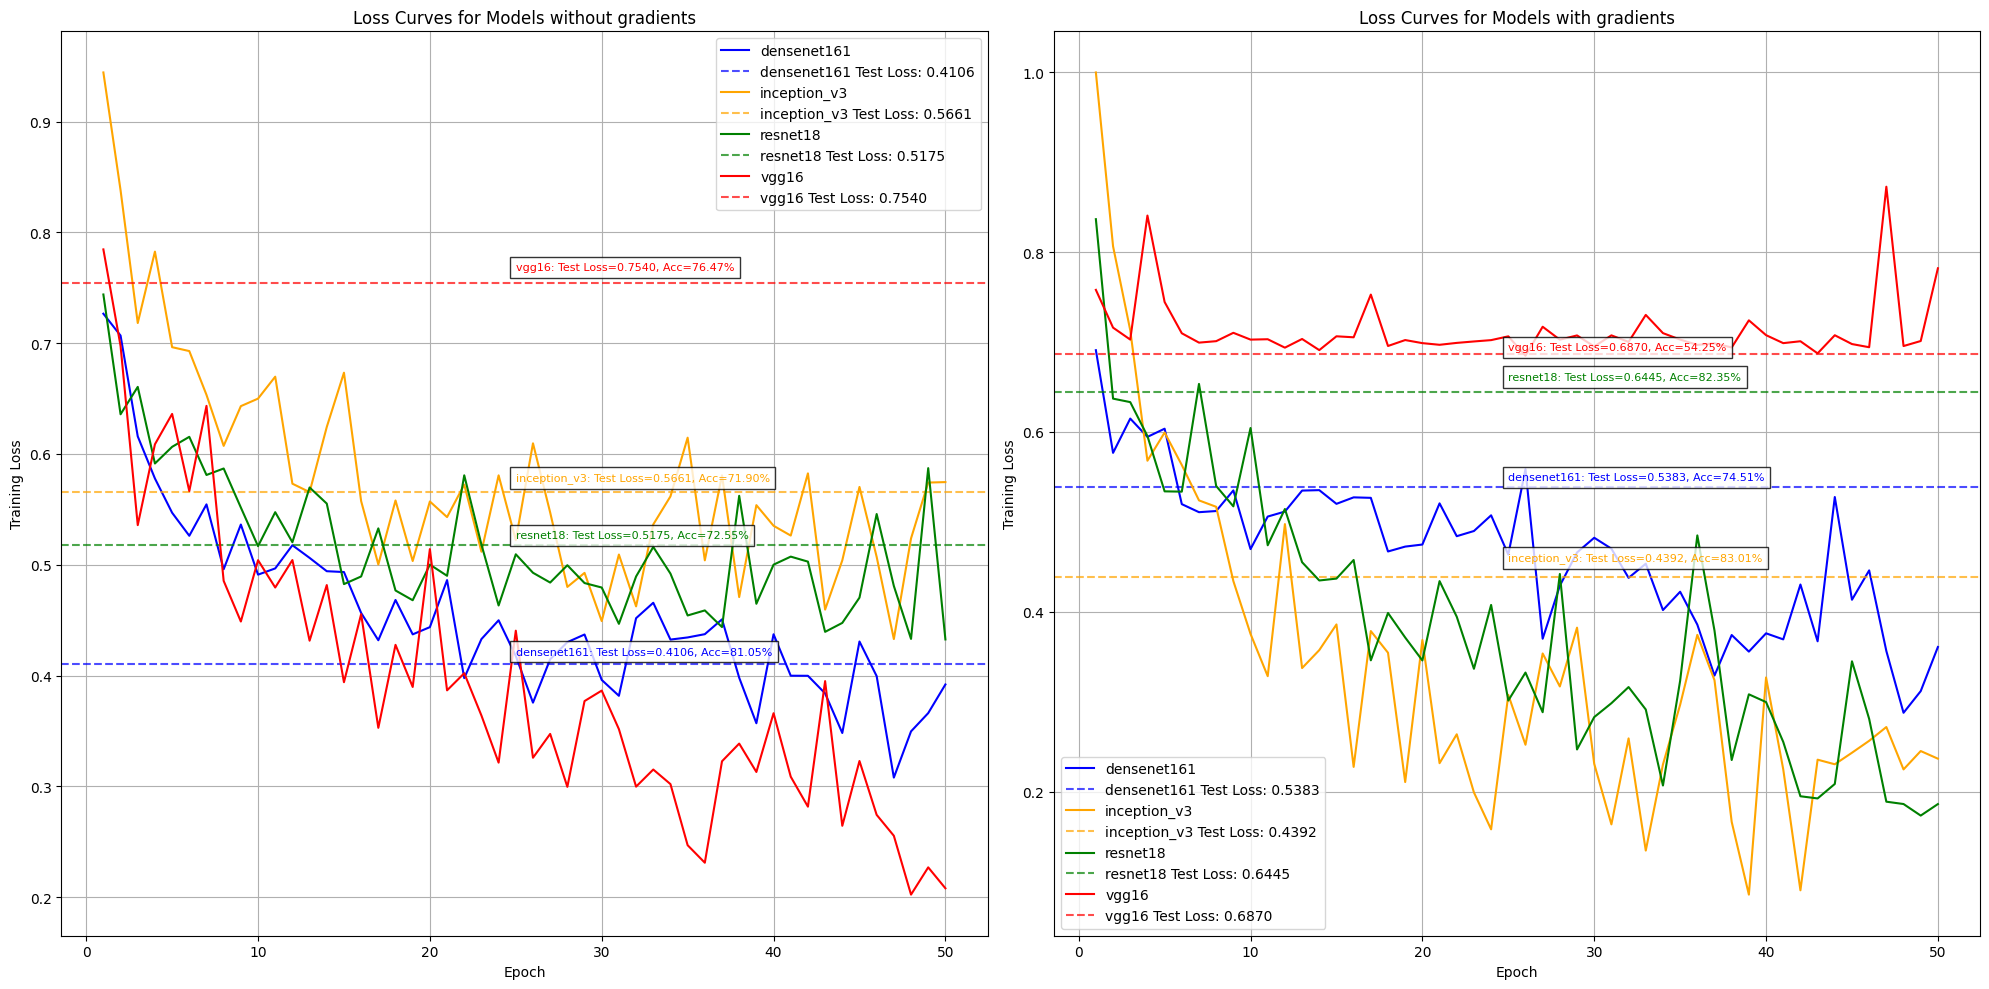

In [20]:
colors = ['blue', 'orange', 'green', 'red'] 

plt.figure(figsize=(20, 10))

# Models with requires_grad=True
plt.subplot(1, 2, 1)
color_idx = 0
for i, (model_name, loss_history, test_loss, test_accuracy) in enumerate(zip(
    results_no_grad['Model'], results_no_grad['Train Loss History'], results_no_grad['Test Loss'], results_no_grad['Test Accuracy']
)):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name, color=colors[color_idx % len(colors)])
        
    plt.axhline(
        y=test_loss,
        linestyle='--',
        alpha=.7,
        color=colors[color_idx % len(colors)],
        label=f'{model_name} Test Loss: {test_loss:.4f}'
    )
        
    plt.text(
        x=num_epochs * .5,
        y=test_loss + .02 * (max(loss_history) - min(loss_history)),
        s=f'{model_name}: Test Loss={test_loss:.4f}, Acc={test_accuracy:.2f}%',
        fontsize=8,
        color=colors[color_idx % len(colors)],
        bbox=dict(facecolor='white', alpha=.8)
    )
    color_idx += 1   

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Curves for Models without gradients')
plt.legend()
plt.grid(True)

# Models with requires_grad=False
plt.subplot(1, 2, 2)
color_idx = 0
for i, (model_name, loss_history, test_loss, test_accuracy) in enumerate(zip(
    results_grad['Model'], results_grad['Train Loss History'], results_grad['Test Loss'], results_grad['Test Accuracy']
)):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name, color=colors[color_idx % len(colors)])
        
    plt.axhline(
        y=test_loss,
        linestyle='--',
        alpha=.7,
        color=colors[color_idx % len(colors)],
        label=f'{model_name} Test Loss: {test_loss:.4f}'
    )
        
    plt.text(
        x=num_epochs * .5,
        y=test_loss + .02 * (max(loss_history) - min(loss_history)),
        s=f'{model_name}: Test Loss={test_loss:.4f}, Acc={test_accuracy:.2f}%',
        fontsize=8,
        color=colors[color_idx % len(colors)],
        bbox=dict(facecolor='white', alpha=.8)
    )
    color_idx += 1  

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Curves for Models with gradients')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def visualize_predictions(model, data_loader, class_names, device, num_images=10):
    model.eval()
    
    all_images = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            all_images.append(images)
            all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    total_images = len(all_images)
    indices = np.random.choice(total_images, size=min(num_images, total_images), replace=False)
    
    images = all_images[indices].to(device)
    labels = all_labels[indices].to(device)
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
    axes = axes.ravel()
    
    for i in range(len(indices)):
        img = images[i].cpu().numpy().transpose(1, 2, 0)

        true_label = class_names[labels[i].item()]
        pred_label = class_names[predicted[i].item()]
        probs = probabilities[i].cpu().numpy()

        axes[i].imshow(img, cmap=None)
        axes[i].set_title(
            f"True: {true_label}\nPredicted: {pred_label}\n"
            f"P({class_names[0]}): {probs[0]:.2f}, P({class_names[1]}): {probs[1]:.2f}",
            fontsize=10
        )
        axes[i].axis('off')

    for j in range(len(indices), len(axes)):
        axes[j].axis('off')

    plt.show()

class_names = {v: k for k, v in test_dataset.class_to_idx.items()}

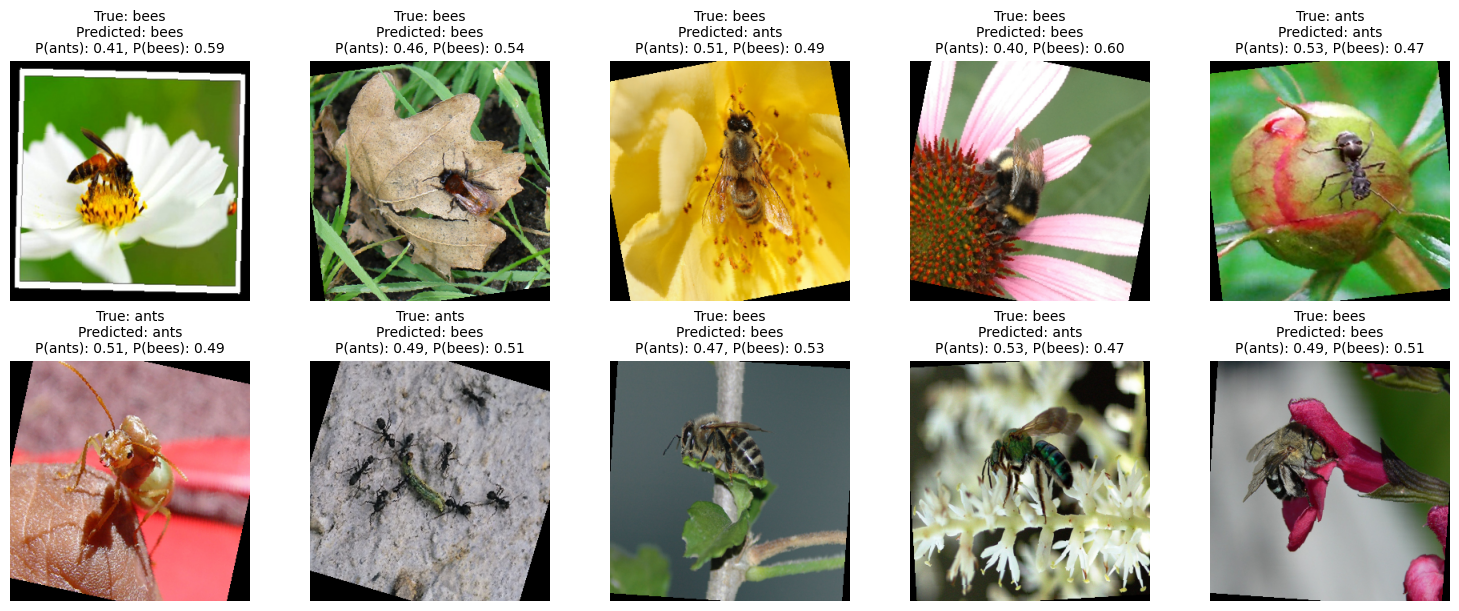

In [24]:
visualize_predictions(get_model('inception_v3', num_classes, requires_grad=True), test_loader, class_names, device, num_images=10)